---
## 1. Introduction

At the heart of any ML system, we have one or more algorithms based on machine learning, deep learning or statistical methods which consume given data to gather knowledge and provide intelligent insights over a period of time. 

However, **the majority of the algorithms are pretty naive by themselves** and cannot work out of the box on raw data. Hence the need for engineering meaningful features from raw data is of utmost importance which can be understood and consumed by these algorithms.

Even though you have a lot of newer methodologies coming in like deep learning and meta-heuristics which aid in automated machine learning, **each problem is domain specific** and better features (suited to the problem) is often the deciding factor of the performance of your system. 
<br>Feature Engineering is an art as well as a science and this is the reason Data Scientists often spend 70% of their time in the data preparation / feature engineering phases

Let us discuss several additional techniques to make feature engineering process more straightforward

In [ ]:
import pandas as pd
import numpy as np
from os.path import join as pjoin
from IPython.core.display import Image, display

pd.options.display.max_rows = 300

** Let's construct some time-based toy-dataset to imitate retail sales**
- several stores (2)
- several departments (4 in 1st and 3 in 2nd store)
- data ranges = 2 full years
- sales are aggregated by hour (store - dept - hourly sales)

In [ ]:
# constructing data
np.random.seed(42)

df = pd.DataFrame()


# add group labels
df['Store'] = [1]*365*8*24 + [2]*365*6*24
df['Dept'] = [i for g in [[i]*365*2*24 for i in range(1,5)] for i in g] + \
        [i for g in [[i]*365*2*24 for i in range(1,4)] for i in g]
# add timestamps
df['Date'] = np.tile(
    A=pd.date_range(start='2016-01-01', periods=365*2*24, freq='h').values,
    reps=7,
)
# add y   
df['Sales'] = np.random.normal(loc=3, scale=1, size=365*14*24)*100

# check sample data
df.head(10)

,Store,Dept,Date,Sales
0,1,1,2016-01-01 00:00:00,349.671415
1,1,1,2016-01-01 01:00:00,286.173570
2,1,1,2016-01-01 02:00:00,364.768854
3,1,1,2016-01-01 03:00:00,452.302986
4,1,1,2016-01-01 04:00:00,276.584663
5,1,1,2016-01-01 05:00:00,276.586304
6,1,1,2016-01-01 06:00:00,457.921282
7,1,1,2016-01-01 07:00:00,376.743473
8,1,1,2016-01-01 08:00:00,253.052561
9,1,1,2016-01-01 09:00:00,354.256004


## 2. Datetime Features: 

### 2.1 Year, month, weekday, is_weekend etc.

Information in datetime/timestamp columns usually holds some explicit (or implicit) knowledge about trends, user dynamics, cyclical activity, holidays etc.
<br>Thus, try always to extract them and check the impact both visually and on cross-validation

In [ ]:
# get year
df['Date_year'] = df.Date.dt.year.astype(np.uint16)
# get month
df['Date_month'] = df.Date.dt.month.astype(np.uint8)
# get weekday
df['Date_weekday'] = df.Date.dt.weekday.astype(np.uint8)
# get week of year
df['Date_weekofyear'] = df.Date.dt.week.astype(np.uint8)
# check weekend
df['Date_is_weekend'] = (df.Date_weekday >= 5)
# hour of day, minute etc. (when provided) can be done in the same fashion ...
df['Date_hour'] = df.Date.dt.hour.astype(np.uint8)

# (as far as data is grouped by week - is_weekend and weekday are constant)
df[[c for c in df.columns if c.startswith('Date')]].head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,Date,Date_year,Date_month,Date_weekday,Date_weekofyear,Date_is_weekend,Date_hour
0,2016-01-01 00:00:00,2016,1,4,53,False,0
1,2016-01-01 01:00:00,2016,1,4,53,False,1
2,2016-01-01 02:00:00,2016,1,4,53,False,2
3,2016-01-01 03:00:00,2016,1,4,53,False,3
4,2016-01-01 04:00:00,2016,1,4,53,False,4
5,2016-01-01 05:00:00,2016,1,4,53,False,5
6,2016-01-01 06:00:00,2016,1,4,53,False,6
7,2016-01-01 07:00:00,2016,1,4,53,False,7
8,2016-01-01 08:00:00,2016,1,4,53,False,8
9,2016-01-01 09:00:00,2016,1,4,53,False,9


But with an hour (the minute, the day of the month ...) everything is **not so perfect**. 
<br>If we use the hour as a real variable, we are somewhat inconsistent with the nature of the data: 0 <23, although 02.01 0:00:00 > 01.01 23:00:00. 
<br>For some tasks, this can be critical. If you encode them as categorical variables, you can create a bunch of categorical features and **lose information about proximity**: the difference between 22 and 23 will be the same as between 22 and 7.

There are also more esoteric approaches to such data. For example, the projection on a circle with the subsequent use of two coordinates:

In [ ]:
from scipy.spatial.distance import euclidean

def harmonic_time(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

# let's see how far it is
print(euclidean(harmonic_time(0), harmonic_time(23)))
print(euclidean(harmonic_time(5), harmonic_time(6)))
print(euclidean(harmonic_time(9), harmonic_time(21)))

0.26105238444010403
0.2610523844401033
2.0


Such transformation **keeps the pointwise distance, which is crucial for some spatial algorithms like kNN, SVM, k-means...**

### 2.2 Date Intervals: time-to-time, differences, distance

Sometimes it's good to check time elapsed from some event (say, some promotion) or compare date-to-date dynamics (say, day to day in different years to see seasonality)

In [ ]:
# check range
dmin = df.Date.dt.date.min()
dmax = df.Date.dt.date.max()

print('Time range: {} to {}'.format(dmin, dmax))

# calculate days from (for example) minimal datetime to given timestamp
df['Date_time_passed'] = (df.Date.dt.date - dmin).dt.days

# calculate hour-of-day over year sales (say, 2017-04-01 10:00 to 2016-04-01 10:00)

df['Date_time_sales_year_ago'] = df.groupby(
    [
        df['Store'], df['Dept'],
        df['Date'].dt.month, df['Date'].dt.day, df['Date'].dt.hour
    ]
)['Sales'].shift()

df[
    (df.Date.dt.date.astype(str).isin(['2017-12-01', '2016-12-01']))
    & (df.Store == 1)
    & (df.Dept == 1)
][[
    'Store', 'Dept', 'Date', 'Date_time_passed', 'Sales', 'Date_time_sales_year_ago'
]].fillna(0)

Time range: 2016-01-01 to 2017-12-30


,Store,Dept,Date,Date_time_passed,Sales,Date_time_sales_year_ago
8040,1,1,2016-12-01 00:00:00,335,279.766109,0.000000
8041,1,1,2016-12-01 01:00:00,335,281.675476,0.000000
8042,1,1,2016-12-01 02:00:00,335,155.808964,0.000000
8043,1,1,2016-12-01 03:00:00,335,394.592959,0.000000
8044,1,1,2016-12-01 04:00:00,335,395.317625,0.000000
8045,1,1,2016-12-01 05:00:00,335,378.907520,0.000000
8046,1,1,2016-12-01 06:00:00,335,237.077933,0.000000
8047,1,1,2016-12-01 07:00:00,335,229.329323,0.000000
8048,1,1,2016-12-01 08:00:00,335,170.687775,0.000000
8049,1,1,2016-12-01 09:00:00,335,308.387250,0.000000


## 3. Temporal Features

### 3.1 Temporal features: Cumulatives

Sometimes it's important to incapsulate "all previous" information into each sample within some reasonable group:
Consider, for example, retail domain - customer segmentation:

Say, for specific row, which **represents specific user bill**, 
<br>calculating whether the customer is "new" or "already has history" 
<br>can be simply done with cumulative count over previous bills/visits

<pre>
visit     visits_before
10-10-17      0
17-10-17      1
01-11-17      2
</pre>

Or to compare whether 100$ is a big amount for specific customer, 
<br>we can average his spendings over number of visits
<br>then, for example customer with equal spendings can be separated: (100 / 2) >> (100 / 15)

In [ ]:
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)

# cumulative sum
# calculate cumulative sales by store, department (exclude current timestamp)
df['Sales_cumsum'] = (
    df.groupby(['Store', 'Dept'])['Sales'].cumsum() 
    - df.Sales
)

# cumulative count (~ # of observation withing grouping)
df['Sales_cumcount'] = \
df.groupby(['Store', 'Dept']).cumcount().astype(np.uint16)

# cumulative mean
# calculate cumulative mean hour sales sales by store, department (exclude current row)
df['Sales_cummean'] = (
df['Sales_cumsum'] / df['Sales_cumcount']
).fillna(0) # to impute n/a for 1st row in each group

df[[c for c in df.columns if c.startswith('Sales')]].head(10)

,Sales,Sales_cumsum,Sales_cumcount,Sales_cummean
0,349.671415,0.000000,0,0.000000
1,286.173570,349.671415,1,349.671415
2,364.768854,635.844985,2,317.922493
3,452.302986,1000.613839,3,333.537946
4,276.584663,1452.916825,4,363.229206
5,276.586304,1729.501487,5,345.900297
6,457.921282,2006.087791,6,334.347965
7,376.743473,2464.009073,7,352.001296
8,253.052561,2840.752546,8,355.094068
9,354.256004,3093.805107,9,343.756123


### 3.2 Temporal features: date-to-date / relative ratios

For many algorithms, ratios and shares are better choice then raw values, 
<br>because they usually lie within some predictive bounds, say day-to-day changes in sales etc.
<br>However, **always check** for infinity (caused by zero divisions), NaNs and outliers (say, + 160345% (1600 times) of growth from day5 to day6)
and impute them correctly

In [ ]:
# get hour over hour changes
df['TSales_h_over_h'] = (
    df.Sales -
    df.groupby(['Store', 'Dept'])['Sales'].shift().fillna(0)
)

# the same but ratio
df['TSales_h_over_h_ratio'] = (
    df.Sales /
    df.groupby(['Store', 'Dept'])['Sales'].shift() 
    - 1
).replace([np.inf, -np.inf], np.nan).fillna(0) # don't forget to deal with infinity/NA

# don't forget to clip some outliers, if any
df['TSales_h_over_h_ratio'] = df.TSales_h_over_h_ratio.clip(
    df.TSales_h_over_h_ratio.quantile(0.01),
    df.TSales_h_over_h_ratio.quantile(0.99)
)

# check features 
df[
    ['Sales'] + [c for c in df.columns if c.startswith('TSales_')]
].head(10)

,Sales,TSales_h_over_h,TSales_h_over_h_ratio
0,349.671415,349.671415,0.000000
1,286.173570,-63.497845,-0.181593
2,364.768854,78.595284,0.274642
3,452.302986,87.534132,0.239972
4,276.584663,-175.718323,-0.388497
5,276.586304,0.001642,0.000006
6,457.921282,181.334977,0.655618
7,376.743473,-81.177809,-0.177275
8,253.052561,-123.690912,-0.328316
9,354.256004,101.203443,0.399931


### 3.3 Temporal features: Rollings (window-based calculations)

When the dynamics tends to be **non-stationary**, it's better to use 
<br>features with **rolling windows of fixed length** 
<br>over cumulative features (which holds all information from the beginning and are less adaptive to catch changes)

In [ ]:
# let's calculate some window aggregation over previous 4 hours

# mean rolling sales (4-hour window)
df['RSales_4h_mean'] = \
df.groupby(['Store', 'Dept'])['Sales'].shift(1).rolling(4).mean().fillna(0)
# maximum rolling sales
df['RSales_4h_max'] = \
df.groupby(['Store', 'Dept'])['Sales'].shift(1).rolling(4).max().fillna(0)
# rolling median (or any similar function can be used here)
df['RSales_4h_median'] = \
df.groupby(['Store', 'Dept'])['Sales'].shift(1).rolling(4).median().fillna(0)

# check features 
df[
    ['Sales'] + [c for c in df.columns if c.startswith('RSales')]
].head(10)

,Sales,RSales_4h_mean,RSales_4h_max,RSales_4h_median
0,349.671415,0.000000,0.000000,0.000000
1,286.173570,0.000000,0.000000,0.000000
2,364.768854,0.000000,0.000000,0.000000
3,452.302986,0.000000,0.000000,0.000000
4,276.584663,363.229206,452.302986,357.220135
5,276.586304,344.957518,452.302986,325.471212
6,457.921282,342.560702,452.302986,320.677579
7,376.743473,365.848809,457.921282,364.444645
8,253.052561,346.958930,457.921282,326.664889
9,354.256004,341.075905,457.921282,326.664889


## 4. Geo Features

Term "geocoding" refers to converting a proper street address like "123 Main St, San Diego, CA 92101" into a lat/lon pair

Let's discuss geocoding / inverse geocoding tricks regarding Starbucks dataset:
<br>https://www.kaggle.com/starbucks/store-locations/data

In [ ]:
!pip install geopy
!pip install reverse_geocoder
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 5.1 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268087 sha256=22262965f68561813ea8c69affbb380caf372c87b08ddc59d0068c5c5662ddac
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install geopy
# pip install reverse_geocoder
# pip install folium

# map plotting
import folium
from folium.plugins import HeatMap

# offline tool for reverse geocoding (given (lat,long) get closest big city)
import reverse_geocoder as rg

# tools for online geocoding (wrappers to OpenStreetMap API etc.)
import geopy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_geo = pd.read_csv("/content/drive/MyDrive/projector_course_data/geo-data-starbucks_stores.csv")

# drop NaNs from geo coordinates
df_geo = df_geo[
    ~df_geo['Longitude'].isnull()
].reset_index()
print(df_geo.shape)

# see sample
df_geo.head(5)

(25599, 14)


,index,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [ ]:
# prepare geo data
data = np.hstack(
    [
        df_geo[['Latitude', 'Longitude']].values, # coordinates
        np.ones((df_geo.shape[0], 1)) # point intensity
    ]
).tolist()

# visualize Starbuck cafes on map
m = folium.Map([0, 0], tiles='OpenStreetMap', zoom_start=1)
HeatMap(data, blur=2, radius=3).add_to(m)
m

### 4.1 Direct Geocoding

Suppose you have address strings which consist of something like country, city etc.
<br>You're aimed to extract (lat,long) pairs to do some visualization, cluster data, check hypothesis etc.

Then **direct geocoding** will help you

The easiest way is to use some wrapper to online APIs like **geopy library**

In [ ]:
from geopy.geocoders import Nominatim
# OpenStreetMap geocoder example
geolocator = Nominatim()

location = geolocator.geocode("Sheikh Khalifa Bin Zayed St., Ajman", language='en')
print(location.address, '\n')
print((location.latitude, location.longitude), '\n')
print(location.raw)

/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Sheikh Khalifa Bin Zayed Street, Al sawan, Ajman, Ajman Emirate, United Arab Emirates 

(25.3928644, 55.4326204) 

{'place_id': 121618330, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 68654203, 'boundingbox': ['25.3920488', '25.3936598', '55.4276486', '55.4384858'], 'lat': '25.3928644', 'lon': '55.4326204', 'display_name': 'Sheikh Khalifa Bin Zayed Street, Al sawan, Ajman, Ajman Emirate, United Arab Emirates', 'class': 'highway', 'type': 'primary', 'importance': 0.71}


### 4.2 Reverse Geocoding

Suppose you have only (latitude,longitude) pairs and you want to extract some useful information regarding country, city etc.

Then it's time to do some **reverse geocoding** 
<br>(the fastest yet precise method is to use offline methods like **reverse_geocoder package**)

Pros:
- Fast
- Offline

Contras:
- Not so precise (comparable to online APIs)
- Good results only for well-known locations

In [ ]:
%%time
gdata = tuple(map(tuple, df_geo[['Latitude', 'Longitude']].values))
# query offline and build a dataframe atop of it
df_reverse = pd.DataFrame(rg.search(gdata))

Loading formatted geocoded file...
CPU times: user 1.38 s, sys: 187 ms, total: 1.57 s
Wall time: 1.67 s


In [ ]:
# check generated data
df_reverse.head(10)

,lat,lon,name,admin1,admin2,cc
0,42.50729,1.53414,les Escaldes,Escaldes-Engordany,,AD
1,25.41111,55.43504,Ajman,Ajman,,AE
2,25.41111,55.43504,Ajman,Ajman,,AE
3,24.46667,54.36667,Abu Dhabi,Abu Dhabi,,AE
4,24.46667,54.36667,Abu Dhabi,Abu Dhabi,,AE
5,24.46667,54.36667,Abu Dhabi,Abu Dhabi,,AE
6,24.46667,54.36667,Abu Dhabi,Abu Dhabi,,AE
7,24.46667,54.36667,Abu Dhabi,Abu Dhabi,,AE
8,24.19167,55.76056,Al Ain,Abu Dhabi,,AE
9,24.46667,54.36667,Abu Dhabi,Abu Dhabi,,AE


In [ ]:
# check quality (country code)
print('Country correct percentage: {:.3f}'.format(
    (df_reverse.cc == df_geo.Country).sum() / df_geo.shape[0]
))

# only big cities are found (or the problem is in exact naming)
print('City correct percentage: {:.3f}'.format(
    (df_reverse.admin1.str.lower() == df_geo.City.str.lower()).sum() / df_geo.shape[0]
))

Country correct percentage: 0.992
City correct percentage: 0.079


In [ ]:
# let's have a look on exactly found cities
df_geo[
    df_reverse.admin1.str.lower() == df_geo.City.str.lower()
].City.str.upper().unique()

array(['AJMAN', 'ABU DHABI', 'DUBAI', 'BUENOS AIRES', 'MENDOZA',
       'SANTA FE', 'CORDOBA', 'SALZBURG', 'MANAMA', 'MUHARRAQ',
       'SANTA CRUZ', 'RIO DE JANEIRO', 'SAO PAULO', 'QUEBEC', 'BERN',
       'FRIBOURG', 'ZUG', 'ZURICH', 'VALPARAISO', 'TSUEN WAN',
       'YUEN LONG', 'MACAU', 'BOGOTA D.C.', 'ALAJUELA', 'SAN JOSE',
       'LIMASSOL', 'PRAHA', 'BERLIN', 'BREMEN', 'HAMBURG', 'MADRID',
       'VALENCIA', 'MURCIA', 'CRETE', 'GUATEMALA', 'BUDAPEST', 'BALI',
       'BANTEN', 'LAMPUNG', 'AMMAN', 'IRBID', 'AOMORI', 'IWATE', 'AKITA',
       'YAMAGATA', 'FUKUSHIMA', 'TOCHIGI', 'SAITAMA', 'CHIBA', 'TOKYO',
       'NIIGATA', 'TOYAMA', 'ISHIKAWA', 'FUKUI', 'NAGANO', 'GIFU',
       'SHIZUOKA', 'KYOTO', 'OSAKA', 'TOTTORI', 'NARA', 'WAKAYAMA',
       'OKAYAMA', 'HIROSHIMA', 'YAMAGUCHI', 'TOKUSHIMA', 'KOCHI',
       'FUKUOKA', 'KUMAMOTO', 'NAGASAKI', 'OITA', 'MIYAZAKI', 'KAGOSHIMA',
       'PHNOM PENH', 'SEOUL', 'BUSAN', 'DAEGU', 'INCHEON', 'GWANGJU',
       'DAEJEON', 'ULSAN', 'GYEONGGI-D

Another alternative is to use **online API of geocoding services like OSM**:

Pros:
- Precise and flexible

Contras:
- May have request limit and/or be paid
- May not implement batch requests -> speed of **1 address/sec is not enough for larger datasets**

In [ ]:
test = geolocator.reverse((25.42, 55.47), language='en')
print(test.address, '\n')
print((test.latitude, test.longitude), '\n')
print(test.raw)

Abu Mousa Island Street, Meshairef, Ajman, Ajman Emirate, United Arab Emirates 

(25.420173442247002, 55.470453262405485) 

{'place_id': 154918532, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 205414475, 'lat': '25.420173442247002', 'lon': '55.470453262405485', 'display_name': 'Abu Mousa Island Street, Meshairef, Ajman, Ajman Emirate, United Arab Emirates', 'address': {'road': 'Abu Mousa Island Street', 'suburb': 'Meshairef', 'city': 'Ajman', 'state': 'Ajman Emirate', 'ISO3166-2-lvl4': 'AE-AJ', 'country': 'United Arab Emirates', 'country_code': 'ae'}, 'boundingbox': ['25.4147984', '25.4222706', '55.4695028', '55.4722372']}


## 5. Regular Expressions Features


A regular expression (or RE) specifies a set of strings that matches it; 
<br>the functions based on RE let you check if a particular string matches a given regular expression (or if a given regular expression matches a particular string, which comes down to the same thing).

Regular expressions can be concatenated to form new regular expressions; if A and B are both regular expressions, then AB is also a regular expression. 
<br>In general, if a string p matches A and another string q matches B, the string pq will match AB. This holds unless A or B contain low precedence operations; boundary conditions between A and B; or have numbered group references. 
<br>Thus, complex expressions can easily be constructed from simpler primitive expressions like the ones described here. For details of the theory and implementation of regular expressions, consult the Friedl book referenced above, or almost any textbook about compiler construction.
</pre>

see [some documentation in Python](https://docs.python.org/3.6/library/re.html) regarding REGEXES

One can simply search text for patterns like emails, phone numbers, suspicious sequences, uppercase sequences etc. and form useful features atop of that

Let's ensure this approach works on a classical [spam collection dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [ ]:
# load spam data
df_regex = pd.read_csv("/content/drive/MyDrive/projector_course_data/regexes-spam.csv", encoding="latin1")
df_regex = df_regex[df_regex.columns[:2]]
df_regex.columns = ["y", "text"]

df_regex.head()

,y,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
import re

# define some REGEXES

# the one that match emails
regex_email = re.compile(
    r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)",
    re.U | re.M
)

# the one that match variety of phone number formats
regex_phone = re.compile(
    r"""
    ((?:\+|00)[17](?: |\-)?|(?:\+|00)[1-9]\d{0,2}(?: |\-)?|
    (?:\+|00)1\-\d{3}(?: |\-)?)?(0\d|\([0-9]{3}\)|[1-9]{0,3})
    (?:((?: |\-)[0-9]{2}){4}|((?:[0-9]{2}){4})|
    ((?: |\-)[0-9]{3}(?: |\-)[0-9]{4})|([0-9]{7}))
    """,
    re.M | re.I | re.VERBOSE
)

# the one that match capitalized sequences like John Doe and Barack Obama
regex_capitalized_sequences = re.compile(
    r"""
    ([A-Z][a-z]+(?=\s[A-Z])(?:\s[A-Z][a-z]+)+)
    """,
    re.U | re.M | re.VERBOSE
)

# the one that matches some currency expressions, like 100USD, 1.25$, £123,334 etc.
regex_currency = re.compile(
    r"""
    (?:\-|\+)*[0-9]+(?:[\.\,]{1}[0-9]+)*\s*(?:\$|£|usd)|
    (?:\-|\+)*(?:\$|£|usd)\s*[0-9]+(?:[\.\,]{1}[0-9]+)*
    """,
    re.M | re.I | re.VERBOSE
)

# the one that matches some uppercase sequences like 'WINNER' 
# or 'ENLARGE YOUR PE*IS WITHOUT REGISTRATION AND SMS' :)
regex_uppercase_words = re.compile(
    r"""
    ([A-Z]{3,}[A-Z0-9]*\s*)+
    """,
    re.M | re.VERBOSE
)

# the one to capture exclamations (exclamation / question marks)
regex_exclamations = re.compile(
    r'[!?]+',
    re.I | re.M
)

In [ ]:
# try it and calculate presence/absence of that patterns within texts
df_regex['has_emails'] = df_regex.text.apply(
    lambda x: True if re.findall(regex_email, x) else False
)

df_regex['has_phones'] = df_regex.text.apply(
    lambda x: True if re.findall(regex_phone, x) else False
)

df_regex['has_possible_names'] = df_regex.text.apply(
    lambda x: True if re.findall(regex_capitalized_sequences, x) else False
)

df_regex['has_possible_currency'] = df_regex.text.apply(
    lambda x: True if re.findall(regex_currency, x) else False
)

df_regex['has_uppercase_words'] = df_regex.text.apply(
    lambda x: True if re.findall(regex_uppercase_words, x) else False
)

df_regex['has_exclamations'] = df_regex.text.apply(
    lambda x: True if re.findall(regex_exclamations, x) else False
)

In [ ]:
# check Y distributions over found features and see how them separate classes
print(df_regex.pivot_table(
    values='text', index='y', columns='has_phones', aggfunc='count'))

print('\n', df_regex.pivot_table(
    values='text', index='y', columns='has_possible_names', aggfunc='count'))

print('\n', df_regex.pivot_table(
    values='text', index='y', columns='has_possible_currency', aggfunc='count'))

print('\n', df_regex.pivot_table(
    values='text', index='y', columns='has_uppercase_words', aggfunc='count'))

print('\n', df_regex.pivot_table(
    values='text', index='y', columns='has_exclamations', aggfunc='count'))

has_phones  False  True
y                      
ham          4822     3
spam          328   419

 has_possible_names  False  True
y                              
ham                  4643   182
spam                  424   323

 has_possible_currency  False  True
y                                 
ham                     4814    11
spam                     492   255

 has_uppercase_words  False  True
y                               
ham                   4483   342
spam                   198   549

 has_exclamations  False  True
y                            
ham                3348  1477
spam                313   434


In [ ]:
# let's check feature impact - that's huge performance! 
# without even text features like tf-idf etc.

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# define simple train/test split and baseline RF classifier
Xtr, Xtst, ytr, ytst,  = train_test_split(
    df_regex[[c for c in df_regex.columns if c.startswith('has_')]].values.astype(np.uint8),
    df_regex.y.map({'spam': 1, 'ham': 0}),
    test_size=0.2,
    stratify=df_regex.y,
    random_state=42,
)

print(Xtr.shape, Xtst.shape, ytr.shape, ytst.shape)

clf = RandomForestClassifier(
    class_weight='balanced', 
    n_estimators=50, 
    random_state=42,
    n_jobs=-1,
)

# fit and predict
clf.fit(Xtr, ytr)
y_pred = clf.predict(Xtst)

# see good results
print('\n', classification_report(ytst, y_pred, digits=3))

(4457, 6) (1115, 6) (4457,) (1115,)

               precision    recall  f1-score   support

           0      0.985     0.913     0.948       966
           1      0.618     0.913     0.737       149

    accuracy                          0.913      1115
   macro avg      0.802     0.913     0.843      1115
weighted avg      0.936     0.913     0.920      1115



## 6. Specific Model Output as a Feature

Given a **heterogenous dataset**, sometimes it's useful to train single model, 
<br>reported to perform well on particular feature subset (or even 1 feature) 
<br>and then to include its predictions as a feature

Say, given information about Lots (price, manufacturer, type, textual description etc.), 
<br>train text-based model (NN etc.) **on textual data only** and include its output as a feature 
<br>for your main model atop of it

This approach is a corner case of **stacking techniques**

**Be sure to do it properly with out-of-fold predictions to prevent data leaks!**

We'll use the same Spam dataset (as before) to demonstrate it here
<br>For simplicity we'll use character-n-grams tf-idf + logistic regression pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# feature extractor
tfidf = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 2),
    max_df=0.8,
    min_df=2,
    max_features=5000,
    #lowercase=False # new
)

# classifier
model = LogisticRegression(
    C=1, 
    random_state=42,
    class_weight='balanced'
)

# pipeline
pipe = Pipeline(
    [
        ('fe',  tfidf),
        ('clf', model)
    ]
)

In [ ]:
# prepare texts for train/test
texttr, texttst = train_test_split(
    df_regex.text,
    test_size=0.2,
    stratify=df_regex.y,
    random_state=42,
)

In [ ]:
# cross-validation strategy
n_folds = 7
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
indices = list(kf.split(texttr, ytr))

In [ ]:
# define placeholders for oof-predictions
ytr_oof = np.zeros(ytr.shape)
ytst_oof = np.zeros((ytst.shape[0], n_folds))

for (i, (tr, oof)) in enumerate(indices):
    pipe.fit(texttr.values[tr], ytr.values[tr]) # train model
    ytr_oof[oof] = pipe.predict_proba(texttr.values[oof])[:, 1] # get oof-train predictions
    # get predictions for test
    ytst_oof[:, i] = pipe.predict_proba(texttst.values)[:, 1]
    
ytst_oof = ytst_oof.mean(axis=1)

In [ ]:
# check this feature - no leaks
from sklearn.metrics import f1_score

# train
print(classification_report(ytr.values, (ytr_oof > 0.5).astype(int)))
# test
print(classification_report(ytst.values, (ytst_oof > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3859
           1       0.93      0.94      0.94       598

    accuracy                           0.98      4457
   macro avg       0.96      0.97      0.96      4457
weighted avg       0.98      0.98      0.98      4457

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.95      0.92      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [ ]:
# add this feature to features and retrain model (initial RandomForestClassifier)

# recap old results
print('\n', classification_report(ytst, y_pred, digits=3))

# add new meta-feature, fit and predict
clf.fit(
    np.hstack(
        [
            Xtr, 
            ytr_oof.reshape((-1,1))
        ]
    ), 
    ytr
    
)
y_pred2 = clf.predict(
    np.hstack(
        [
            Xtst, 
            ytst_oof.reshape((-1,1))
        ]
    )
)

# see new, improvements
print('\n', classification_report(ytst, y_pred2, digits=3))


               precision    recall  f1-score   support

           0      0.985     0.913     0.948       966
           1      0.618     0.913     0.737       149

    accuracy                          0.913      1115
   macro avg      0.802     0.913     0.843      1115
weighted avg      0.936     0.913     0.920      1115


               precision    recall  f1-score   support

           0      0.992     0.994     0.993       966
           1      0.959     0.946     0.953       149

    accuracy                          0.987      1115
   macro avg      0.975     0.970     0.973      1115
weighted avg      0.987     0.987     0.987      1115



## 7. Web / IP Features

Given some web information, sometimes it's useful to extract meta-information 
<br>from fields like **IP adress** or **user agent**:

For example, given IP, you can extract:
- country
- city
- (sometimes) precise geo-coordinates

and be able to guess:
- whether target is using proxy
- add a feature to detect fraud by comparing country of a client with country of an IP address
- etc.

In [ ]:
!pip install maxminddb-geolite2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.1 MB 1.7 MB/s 
     |████████████████████████████████| 330 kB 46.0 MB/s 
  Created wheel for maxminddb-geolite2: filename=maxminddb_geolite2-2018.703-py3-none-any.whl size=26407052 sha256=d9672c46ec6f61e26dd220019421eb7da386803f2e6036db7f18d7ee6d112c51
  Stored in directory: /root/.cache/pip/wheels/21/f8/f5/c3d091f638042b802aa461ae6087b6f4106df7bf9a46ad4114
  Created wheel for maxminddb: filename=maxminddb-2.2.0-py2.py3-none-any.whl size=16357 sha256=0ec715c53792269de018d4f804f3ee10a604b52443eb5e8a386044428d609eec
  Stored in directory: /root/.cache/pip/wheels/3b/eb/d9/b4407ec5d0ccddce61c8d2f4db72a68a77a04adea2245b98ef
Successfully built maxminddb-geolite2 maxminddb


In [ ]:
# pip install maxminddb-geolite2
from geolite2 import geolite2

def get_ip_info(ip_address_list, fields=None):
    with geolite2 as gl2:
        ip_reader = gl2.reader()
        results = []
        for addr in ip_address_list:
            try:
                info = ip_reader.get(addr)
                if fields is not None:
                    info = {k:v for (k,v) in info.items() if k in fields}
                results.append(info)
            except ValueError:
                print('Cannot extract info for address: {}'.format(addr))
                results.append(dict())
            
        return results

In [ ]:
import json
print(
    json.dumps(
        get_ip_info(['212.90.62.130', '95.164.54.98', '1.1.1.1']),
        indent=4,
        ensure_ascii=False
    )
)

[
    {
        "city": {
            "geoname_id": 703448,
            "names": {
                "de": "Kyiw",
                "en": "Kiev",
                "es": "Kiev",
                "fr": "Kiev",
                "ja": "キエフ",
                "pt-BR": "Kiev",
                "ru": "Киев"
            }
        },
        "continent": {
            "code": "EU",
            "geoname_id": 6255148,
            "names": {
                "de": "Europa",
                "en": "Europe",
                "es": "Europa",
                "fr": "Europe",
                "ja": "ヨーロッパ",
                "pt-BR": "Europa",
                "ru": "Европа",
                "zh-CN": "欧洲"
            }
        },
        "country": {
            "geoname_id": 690791,
            "iso_code": "UA",
            "names": {
                "de": "Ukraine",
                "en": "Ukraine",
                "es": "Ucrania",
                "fr": "Ukraine",
                "ja": "ウクライナ共和国",
                "pt

Another good source of information is **user-agent**

You can extract some useful features like:
- is_mobile
- browser name and version
- OS
- ...

In [ ]:
!pip install user-agents

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# pip install user-agents
import user_agents

# android smartphone example
ua1 = "Mozilla/5.0 (Linux; Android 7.0; SM-G930VC Build/NRD90M; wv)" +\
" AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/58.0.3029.83 Mobile Safari/537.36"

# apple pc example
ua2 = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9" +\
"(KHTML, like Gecko) Version/9.0.2 Safari/601.3.9"

# bot/spider example
ua3 = "Mozilla/5.0 (compatible; Googlebot/2.1; +http://www.google.com/bot.html)"

ua_info = [user_agents.parse(ua) for ua in (ua1, ua2, ua3)]

In [ ]:
for ua in ua_info:
    print('\n'+'='*50)
    # check whether it's bot
    print('Is bot: {}'.format(ua.is_bot))

    # see browser
    print('Browser info: {}'.format(ua.browser))

    # see device OS
    print('OS info: {}'.format(ua.os))

    # see device type, its mobile
    print('Device type (mobile, pc, tablet): {}'.format((ua.is_mobile, ua.is_pc, ua.is_tablet)))

    # print the whole extracted info about device
    print('\n', ua)


Is bot: False
Browser info: Browser(family='Chrome Mobile WebView', version=(58, 0, 3029), version_string='58.0.3029')
OS info: OperatingSystem(family='Android', version=(7, 0), version_string='7.0')
Device type (mobile, pc, tablet): (True, False, False)

 Samsung SM-G930VC / Android 7.0 / Chrome Mobile WebView 58.0.3029

Is bot: False
Browser info: Browser(family='Safari', version=(9, 0, 2), version_string='9.0.2')
OS info: OperatingSystem(family='Mac OS X', version=(10, 11, 2), version_string='10.11.2')
Device type (mobile, pc, tablet): (False, True, False)

 PC / Mac OS X 10.11.2 / Safari 9.0.2

Is bot: True
Browser info: Browser(family='Googlebot', version=(2, 1), version_string='2.1')
OS info: OperatingSystem(family='Other', version=(), version_string='')
Device type (mobile, pc, tablet): (False, False, False)

 Spider / Other / Googlebot 2.1


## 8. Cluster Labels as Features

Suppose you have some data you believe some structure encoded within.
Then you can check your hypothesis by conducting dimensionality reduction (to ensure the structure is present) and clustering it (to add cluster labels as an additional feature to your model)

There are a bunch of clustering / dimensionality reduction algorithms with own strengts / weaknesses
<br>You can have a look [here](http://scikit-learn.org/stable/modules/clustering.html)

Based on your setup (dataset size, data distribution etc.) 
<br>you should start with simplier approaches (say, PCA + K-means) and 
<br>(if possible) finish with something tricky like UMAP / TSNE + DBSCAN / HDBSCAN

- [hdbscan](http://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html)
- [t-sne example](https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b)
- [UMAP](https://github.com/lmcinnes/umap)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

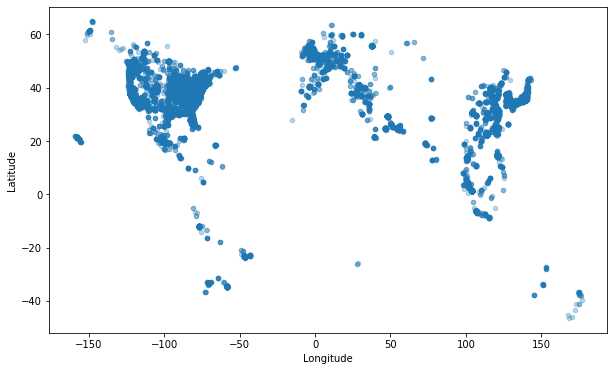

In [ ]:
# suppose you produced some dimensionality reduction and can see existance of some structure
df_geo.plot(x='Longitude', y='Latitude', kind='scatter', figsize=(10,6), alpha=0.3)

In [ ]:
# let's cluster this data and see how it correlates with what we see
from sklearn.cluster import DBSCAN

db = DBSCAN(
    eps=3.5,
    min_samples=15,
    n_jobs=-1,
)

cluster_labels = db.fit_predict(df_geo[['Latitude', 'Longitude']].values)

# check statistics
print('Clusters found: {}'.format(np.unique(cluster_labels).shape[0]))
pd.Series(cluster_labels).value_counts()

Clusters found: 30


 6     15509
 7      3103
 16     2209
 0      2094
 12      642
 1       367
 21      298
 11      246
-1       194
 5       102
 3       101
 28       99
 2        97
 23       81
 20       76
 27       42
 15       41
 25       35
 4        31
 9        28
 13       26
 8        24
 22       24
 18       23
 10       22
 19       19
 17       19
 26       17
 24       15
 14       15
dtype: int64

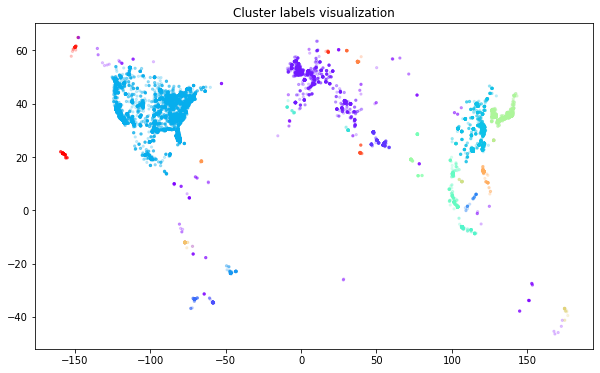

In [ ]:
# visualize cluster labels
plt.figure(figsize=(10,6))
plt.title('Cluster labels visualization')
plt.scatter(
    x=df_geo['Longitude'],
    y=df_geo['Latitude'],
    c=cluster_labels,
    cmap='rainbow',
    alpha=0.2,
    s=5,
)
pass

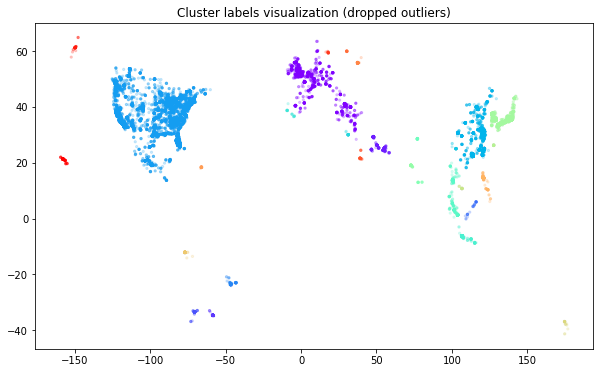

In [ ]:
# visualize cluster labels, except outliers
plt.figure(figsize=(10,6))
plt.title('Cluster labels visualization (dropped outliers)')
plt.scatter(
    x=df_geo['Longitude'][cluster_labels >= 0],
    y=df_geo['Latitude'][cluster_labels >= 0],
    c=cluster_labels[cluster_labels >= 0],
    cmap='rainbow',
    alpha=0.2,
    s=5,
)
pass

## 9. Numerical Feature Binning

Sometimes (more close to rarely) and for some algorithms it's good to do binning of a continuous features
<br>However, be **very accurate with this technique as it loosens information, avaliable in initial feature**

Uses:
- very unstable feature performance (outliers, different distributions in datasets etc.)
- reduce of computational burden from some algorithms (like finding best splits in Decision Trees)

Sometimes it **might help**, the usage is up to you


Let's use [dataset of us-household-income](https://www.kaggle.com/goldenoakresearch/us-household-income-stats-geo-locations) to demonstrate some examples

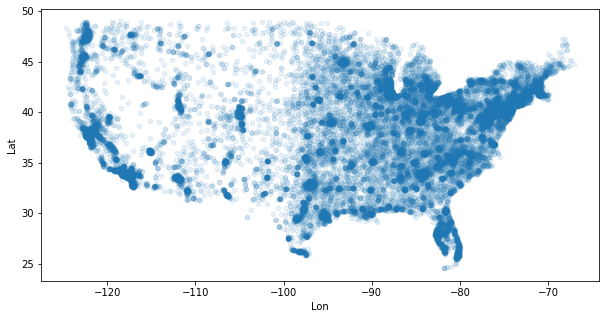

In [ ]:
df_bin = pd.read_csv("/content/drive/MyDrive/projector_course_data/binning-kaggle_income.csv", encoding="latin1")
# drop some "far-away" states
df_bin = df_bin[
    ~df_bin.State_Name.isin(["Rhode Island", "Alaska", "Puerto Rico", "Hawaii"])
]
# visualize geography
df_bin.plot(x="Lon", y="Lat", kind="scatter", figsize=(10,5), alpha=0.1)
pass

In [ ]:
# check sample data
df_bin.head()

,id,State_Code,State_Name,State_ab,County,City,Place,Type,Primary,Zip_Code,Area_Code,ALand,AWater,Lat,Lon,Mean,Median,Stdev,sum_w
0,1011000,1,Alabama,AL,Mobile County,Chickasaw,Chickasaw city,City,place,36611,251,10894952,909156,30.771450,-88.079697,38773,30506,33101,1638.260513
1,1011010,1,Alabama,AL,Barbour County,Louisville,Clio city,City,place,36048,334,26070325,23254,31.708516,-85.611039,37725,19528,43789,258.017685
2,1011020,1,Alabama,AL,Shelby County,Columbiana,Columbiana city,City,place,35051,205,44835274,261034,33.191452,-86.615618,54606,31930,57348,926.031000
3,1011030,1,Alabama,AL,Mobile County,Satsuma,Creola city,City,place,36572,251,36878729,2374530,30.874343,-88.009442,63919,52814,47707,378.114619
4,1011040,1,Alabama,AL,Mobile County,Dauphin Island,Dauphin Island,Town,place,36528,251,16204185,413605152,30.250913,-88.171268,77948,67225,54270,282.320328


**Let's bin some 1D data**

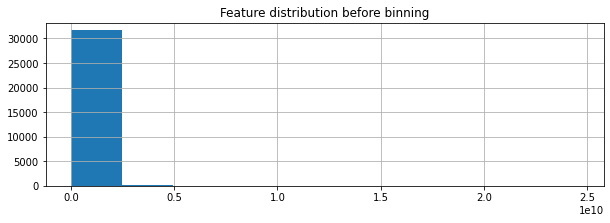

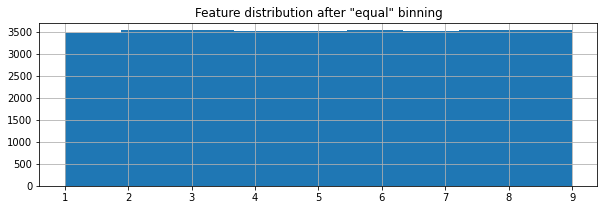

In [ ]:
# Example of quantile binning (each bin holds equal amount data points)
ntiles = 10

# see initial distribution of "Land area" feature - outliers / skewed distribution are present
plt.figure(figsize=(10,3))
plt.title('Feature distribution before binning')
df_bin.ALand.hist(bins=10)

quantiles = [df_bin.ALand.quantile(x) for x in np.linspace(0.0, 1.0, ntiles)]
labels = list(range(1, ntiles))

df_bin['Aland_ntile'] = pd.cut(df_bin.ALand, bins=quantiles, labels=labels)

plt.figure(figsize=(10,3))
plt.title('Feature distribution after "equal" binning')
df_bin['Aland_ntile'].hist(bins=ntiles-1)
pass

**Let's bin some 2D data**

Non-empty grid elements: 81/100
                   City
Lat_grid Lon_grid      
6        8         3647
7        7         1742
         6         1664
6        7         1553
4        2         1498
7        8         1475
4        7         1269
7        9         1209
5        1          929
6        6          834


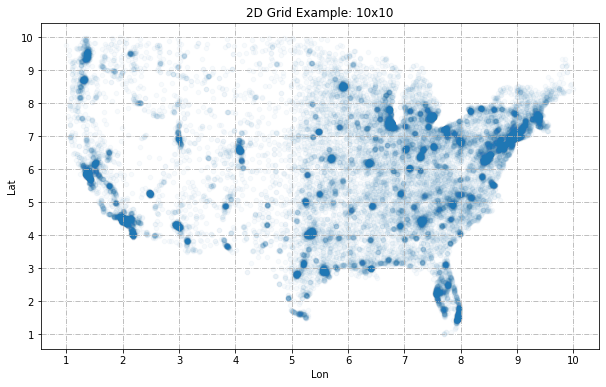

In [ ]:
# let's bin area on grid (25x25)
grid_bins = 10

grid_lat = np.linspace(df_bin.Lat.min(), df_bin.Lat.max(), num=grid_bins)
grid_lon = np.linspace(df_bin.Lon.min(), df_bin.Lon.max(), num=grid_bins)
grid_labels = list(range(1, grid_bins))

df_bin['Lat_grid'] = pd.cut(df_bin.Lat, bins=grid_lat, labels=grid_labels)
df_bin['Lon_grid'] = pd.cut(df_bin.Lon, bins=grid_lon, labels=grid_labels)

# visualize grid
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
ax.set_xticks(grid_lon)
ax.set_yticks(grid_lat)
ax.set_xticklabels(list(range(1, grid_bins+1)))
ax.set_yticklabels(list(range(1, grid_bins+1)))
ax.set_title('2D Grid Example: {}x{}'.format(grid_bins, grid_bins))

gridlines = ax.get_xgridlines() + ax.get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')

df_bin.plot(x='Lon', y='Lat', kind='scatter', figsize=(10,6), alpha=0.03, ax=ax)
plt.grid()

# check the number of non-empty quadrants
print(
    'Non-empty grid elements: {}/{}'.format(
        df_bin.groupby(['Lat_grid', 'Lon_grid']).agg({'City': 'count'}).shape[0],
        grid_bins**2
    )
)

# check the most "dense" quadrants
print(
    df_bin.groupby(['Lat_grid', 'Lon_grid']).agg({'City': 'count'})\
    .sort_values(by='City', ascending=False).head(10)
)

In [ ]:
# visualize the most "dense" quadrant
dense_subset = df_bin[(df_bin.Lat_grid == 6) & (df_bin.Lon_grid == 8)][['Lat', 'Lon']].values
coordinates = np.hstack([dense_subset, np.ones((dense_subset.shape[0], 1))]).tolist()

# visualize it on map
m = folium.Map(
    [grid_lat[grid_lat.shape[0] // 2], grid_lon[grid_lon.shape[0] // 2]], 
    tiles='OpenStreetMap', zoom_start=4
)

HeatMap(coordinates, blur=2, radius=3).add_to(m)
m

## 10. Dimensionality Reduction and Visualization

There are 2 main purposes to use these techniques (might be inclusive):
- Unsupervised dimensionality reduction<br>
(If your number of features is high, it may be useful to reduce it with an unsupervised step prior to supervised steps);
<br>Check [this sklearn guide](http://scikit-learn.org/stable/modules/unsupervised_reduction.html)
- Visualization in 2D/3D (Manifold learning is an approach to non-linear dimensionality reduction. <br>Algorithms for this task are based on the idea that the dimensionality of many data sets is **only artificially high.**);
<br>Check [this sklearn tutorial](http://scikit-learn.org/stable/modules/manifold.html)


The main things to try are:
1. implements transform method
    - **PCA** (linear, is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance)
    - **ICA** (linear, independent component analysis separates a multivariate signal into additive subcomponents that are maximally independent)
    
2. doesn't implement transform method
    - [**T-SNE**](http://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne) (converts affinities of data points to probabilities by optimizing KL-divergence, good catch of "local" structure)
    
3. something fresh-and-new
    - [**UMAP**](https://github.com/lmcinnes/umap)(often performs better at preserving aspects of global structure of the data than t-SNE, supports a wide variety of distance functions)



You have to check out this **[beautiful post regarding main 2D-3D dimensionality reduction techniques](http://colah.github.io/posts/2014-10-Visualizing-MNIST/)**
<br>It has both **background knowledge and intaractive visualization**, very useful for your understanding

## 11. Feature Selection Techniques

Why would you ever need to select features? One may think that this idea may sound counter-intuitive, but in fact there are at least two important reasons to get rid of unimportant features:
- The first is understandable to any data engineer: the more data, the higher the computational complexity. While we play around with toy datasets, the size of the data is not a problem, and for the real highload production, extra hundreds of attributes can be a bottleneck. 
- Another reason is that some algorithms take some noise (uninformative features) as informative features, thus, **fall into overfitting**

### 11.1 Statistical Approaches

The most obvious candidate for deletion is a feature **whose value is invariable (constant)**, i.e. does not contain any information at all. 
<br>If we depart a little from this corner case, it is reasonable to assume that the low-variative features are rather worse than the highly variative ones. 
<br>So one may come to the idea of cuting off the features whose variance is below a certain threshold.

In [ ]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(
    n_samples=200,
    n_features=30,
    n_informative=3,
    n_redundant=4,
    n_classes=2,
    class_sep=0.75,
    random_state=42
)

print(x_data_generated.shape)

print(VarianceThreshold(.7).fit_transform(x_data_generated).shape)

print(VarianceThreshold(.8).fit_transform(x_data_generated).shape)

print(VarianceThreshold(.95).fit_transform(x_data_generated).shape)

(200, 30)
(200, 28)
(200, 28)
(200, 21)


In [ ]:
# let's check other statistical techniques
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

n_folds = 7
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

from sklearn.model_selection import cross_val_score

# the smaller the better
print(
    cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, cv=kf,
                    scoring='neg_log_loss').mean()
)

print(
    cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, cv=kf,
                    scoring='neg_log_loss').mean()
)

print(
    cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, cv=kf, 
                    scoring='neg_log_loss').mean()
)

-0.5018497900601122
-0.473568194341953
-0.4118214915801307


### 11.2 Using meta-model for feature ranking

Another approach is to use some **baseline model to evaluate the features** (the model should be able to clearly show the importance of the features used). 
<br>Two types of models are usually used: some tree-based composition (for example, Random Forest) or a linear model with Lasso regularization, prone to zero weight of weak features.

The approach is intuitively understandable: if the features **are clearly useless in a simple model**, then do not take them into a more complex one.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import make_pipeline


pipe = make_pipeline(
    SelectFromModel(estimator=RandomForestClassifier()),
    LogisticRegression()
)

lr = LogisticRegression()
rf = RandomForestClassifier()

print(
    cross_val_score(lr, x_data_generated, y_data_generated, 
                    scoring='neg_log_loss', cv=kf).mean()
)
print(
    cross_val_score(rf, x_data_generated, y_data_generated, 
                    scoring='neg_log_loss', cv=kf).mean()
)
print(
    cross_val_score(pipe, x_data_generated, y_data_generated, 
                    scoring='neg_log_loss', cv=kf).mean()
)

-0.5018497900601122
-0.36334880058962543
-0.41351596280609787


**However, you should remember that there is a non-zero probability of making things WORSE!**

So, always double-check an impact of such techniques

### 11.3 Brute-Force Feature Selection

Well, the most reliable yet the most computationally heavy approach - simple brute force over subsets of a feature space:
<br>Train a model on a subset of features, store results, continue - calculate metrics for all feature subsets
<br>This approach is called [Exhaustive Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/ExhaustiveFeatureSelector/).

To process all combinations is usually a NP-hard task, thus, let's try to diminish our subset space:
- freeze some small number $N$, iteratively try all combinations with N features, 
- then try all combinations of $N+1$ features in a way that previous N-features part is frozen, and search is aimed to select best (N+1)-th feature atop of it. 
- continue until model converges and/or until max_feature limit is reached

This approach is called [Sequential Feature Selection](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/)

P.s. This algorithm can be inverted and performed in a top-down fashion: start from the full feature set and recursively drop features until significant drop in metrics and/or desired feature_limit is reached - it's called *Recursive Feature Elimination*

In [ ]:
import joblib
import sys

sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
%%time
# pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector

# imitate recursive feature elimination with forward=False
selector = SequentialFeatureSelector(
    LogisticRegression(), 
    scoring='neg_log_loss', 
    verbose=1, 
    k_features=10, 
    forward=False, 
    n_jobs=1,
    cv=kf,
)

selector.fit(x_data_generated, y_data_generated)

print(selector.k_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished
Features: 29/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    1.4s finished
Features: 28/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    1.4s finished
Features: 27/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.3s finished
Features: 26/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    1.2s finished
Features: 25/10[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.2s finished
Features: 24/10[Par

-0.39874140643470557
CPU times: user 19.4 s, sys: 342 ms, total: 19.8 s
Wall time: 20.2 s


## 12. Domain Knowledge and Feature Engineering

1] Consider an example of a classification task from [RTB domain](http://rtb-media.ru/wiki/) (Real Time Bidding).
<br> Given the information about the Ad itself + the information about the user, 
<br>**predict a probability of watching the full Ad (or 30+ sec in case of longer Ads)**
<br>(this allows us to make better bids on **right users with higher probability of conversion** while spending less/same budget)

Suppose the next dataset is given (very close to reality) - main attributes are: 
- **User**:
    - timestamp, 
    - IP address, 
    - uid (unique digital footprint of a user)
    - user-agent
    - (sometimes) some 3rd party augmentation (segment-of-interest raw integer codes etc.)
- **Ad (Impression)**:
    - Ad category (entertainment, real estate, gambling etc.)
    - Ad type (embedded, fullscreen, ad size (w x h), closeable etc.)
    - Ad duration (seconds)
    - ...
    
Suppose you are trying to **improve existing classification model** and after some feature engineering you have the next timestamp-based features (regarding Ad serving):
- month (1-12)
- day_of_week (1-7)
- hour_of_day (0-23)
- minute_in_hour (0-59)
- second_in_minute (0-59)

and feature importance shows **surprisingly high importance of a feature "second_in_minute"** on a cross-validation over another timestamp-based features.
Hovewer, deciding to exclude this feature from matrix X and checking f1-score on test leads to a better result.

Why these situations happen?

The main opportunity here is to **put yourself in the shoes of the client (user)** and think what can **actually have an impact** on your behaviour?
- month / season? maybe, in winter user **may (this is not certain but yet possible)** spend more time watching devices instead of going outside
- weekday (is_weekend or closer to Friday) - definitely, this impacts your decision to watch Ad (being at work / at home etc.)
- hour of a day (or daytime, evening / morning / etc) - sure
- **minute in hour and (especially) second within a minute?** 
<br>**definitely NOT** - if you think of 'yes', just answer - what second within a minute is now? o_0

<br>Another good set of features are rollings / aggregations <br>(in one of the real cases their addition improved **f1-score by 7(!)%** from 75% to 82%):
- average watch rate for particular Ads in the past
- rolling windows (say, of 24h or of x observations before) on user behaviour:
<br>say dynamics of (0,0,0,0,0,1,0,0,1,0) can lead to a features like:
    - rolling_watch_rate_10 = 0.2
    - was_successful_watch_last_3 = True
    - successful_watches_5 = 2
    - etc.
- user "favourite" day to watch an Ad (weekday with highest conversion rate)
- average watch rates for different hours (to catch so-called "prime time")
- etc.

So, **ALWAYS try to double-check what stands behind your features**:
- check common sense (like in an example with second_within_minute
- talk to domain experts
- try to consider yourself a "target" of your algorithm 
<br>(especially works in people-based areas like retail, marketing, advertising etc.)
- check whether there is no "future leakage" in your features:
    - say, make sure you rollings don't contain future samples (or current target)
    - check how aggregations are calculated 

<br><br><br>
Here are some good additional sources that describe 
<br>**the impact of domain knowledge on feature engineering process as well as feature engineering itself**:
- [How to Engineer Features](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/)
- [Best Practices for Feature Engineering](https://elitedatascience.com/feature-engineering-best-practices)
- [What is Feature Engineering](https://medium.com/mindorks/what-is-feature-engineering-for-machine-learning-d8ba3158d97a)

## 13. Target Encoding Features

### Target mean encoding algorithm:
1) Split train on n-folds; (Next steps will be described for fold1 and fold2 as trainset and fold3 as validation. For other combinations everything is the same.) <br>
2) Split new train (fold1 + fold2) on n-folds one more time;

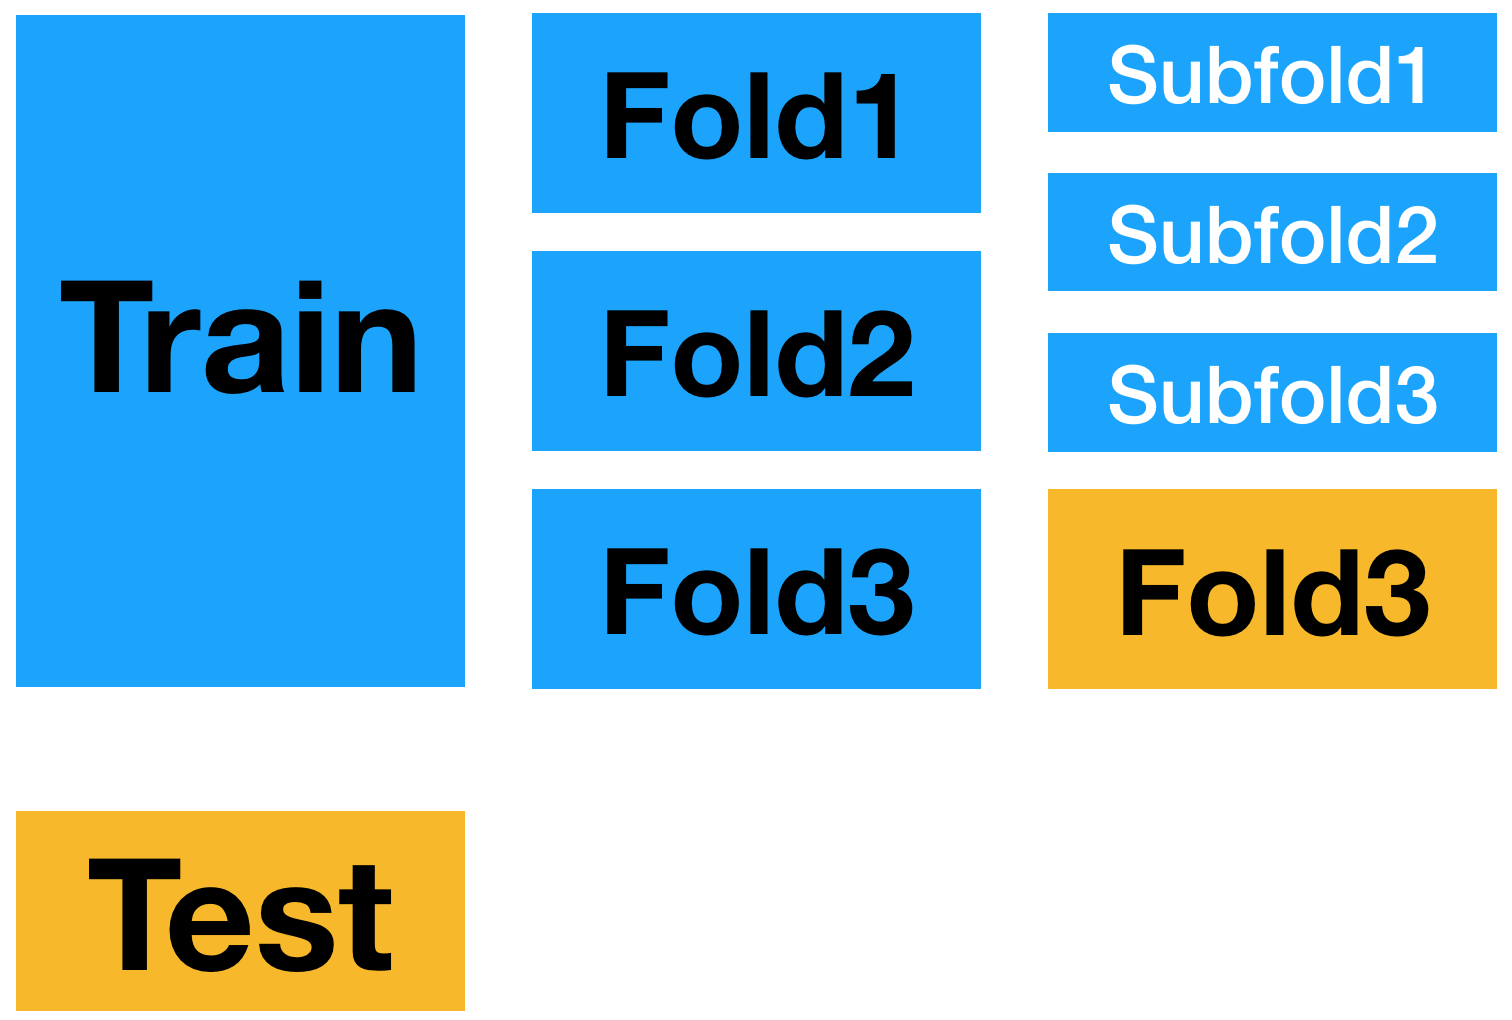

In [ ]:
display(Image('../pictures/mean_encoding.png', unconfined=True, width=750))

---
3) Calculate mean for each categorical feature on `subfold1 and subfold2`, then replace categorical value on `subfold3`. Then repeat the same for different combinations of folds.<br>

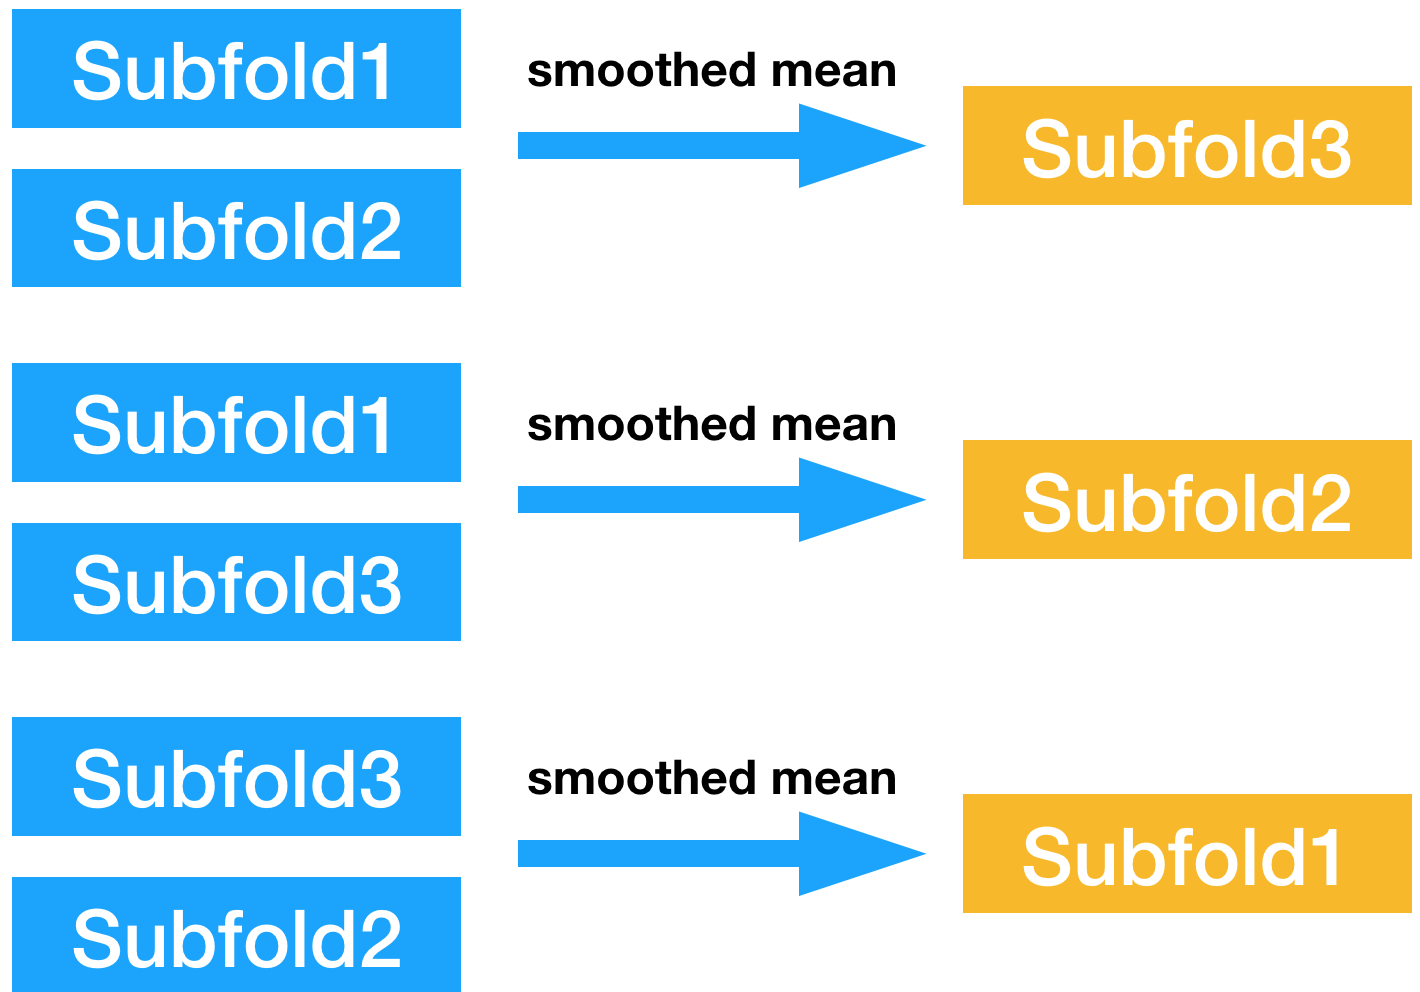

In [ ]:
display(Image('../pictures/mean_encoding2.png', unconfined=True, width=750))

---
4) Calculate mean for each categorical feature on the whole new train (`fold1` + `fold2`) and replace each categorical value on `fold3`.<br>

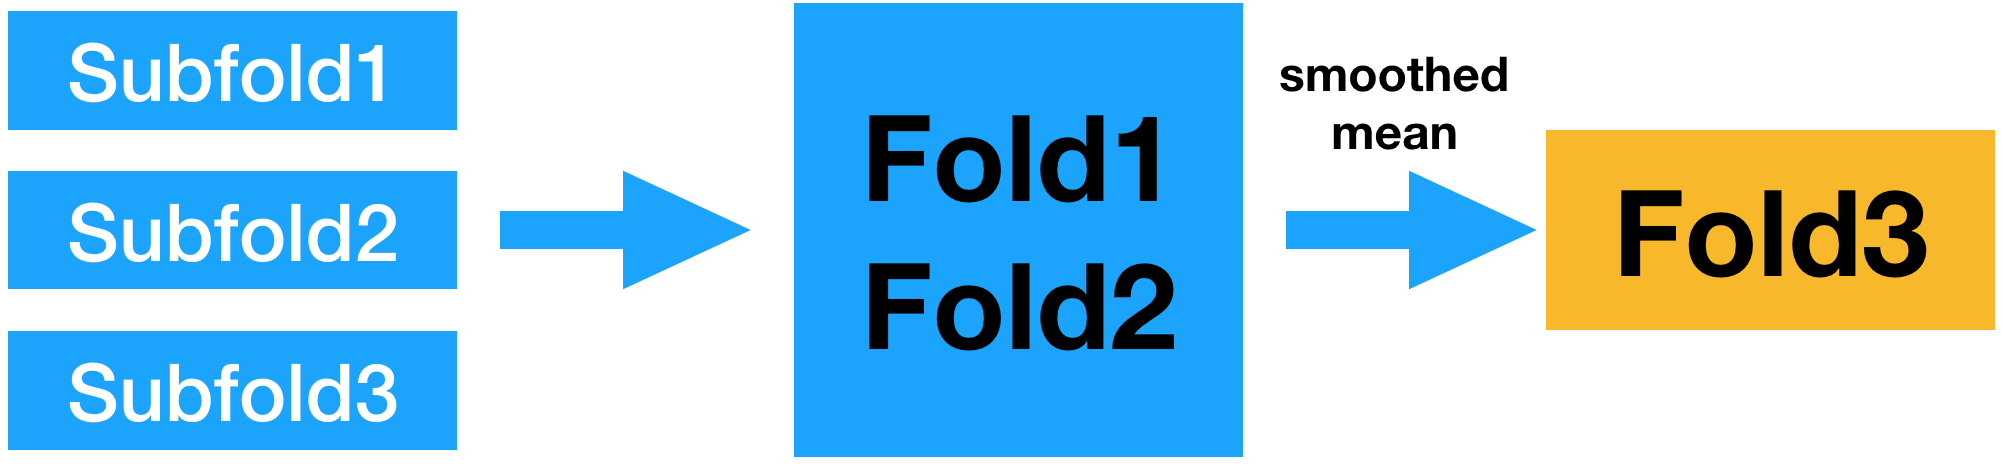

In [ ]:
display(Image('../pictures/mean_encoding3.png', unconfined=True, width=750))

---
5) Perform 2-4 steps for each validation combination.<br>
6) Now you have new datasets for each validation combination.<br>

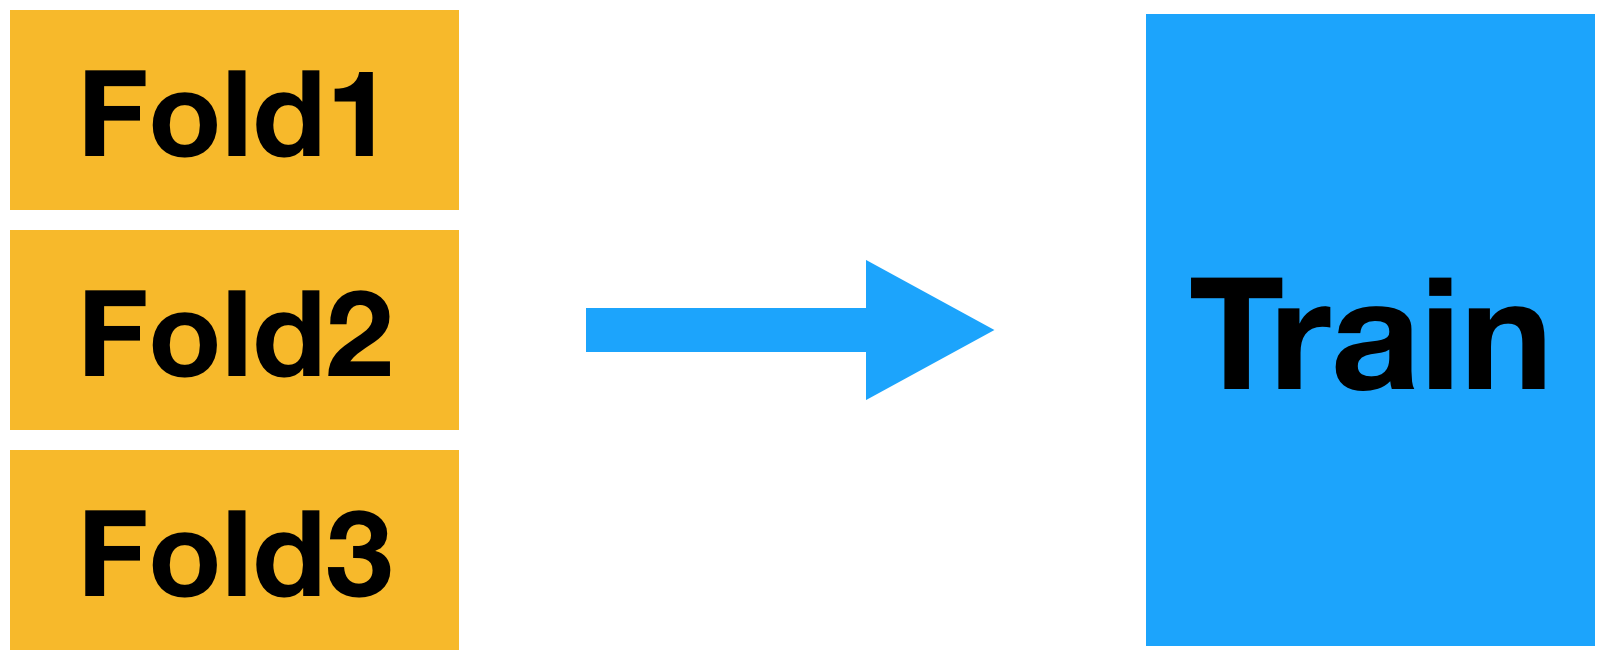

In [ ]:
display(Image('../pictures/mean_encoding4.png', unconfined=True, width=750))

---
7) Calculate mean for each categorical feature on the whole train (`fold1` + `fold2` + `fold3`) and replace each categorical value on `test`.<br>
8) Enjoy :)

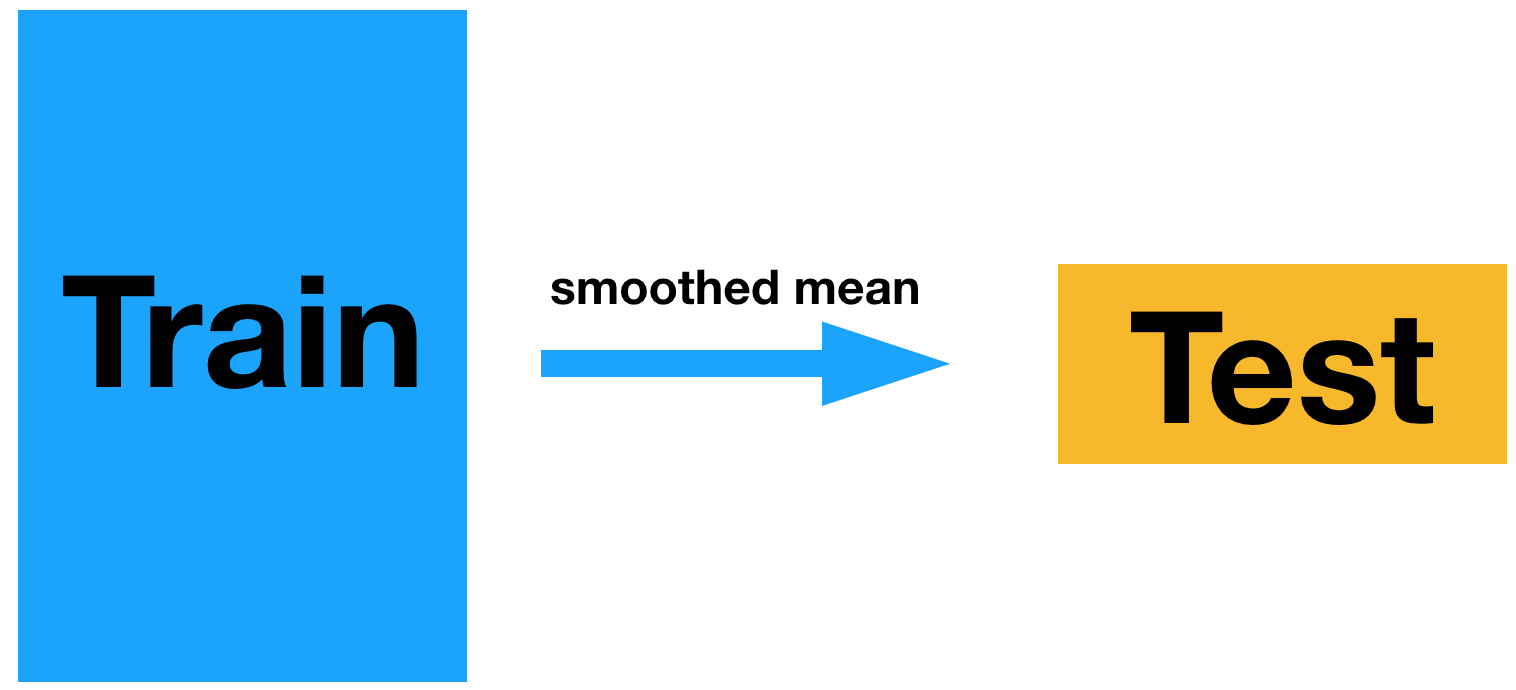

In [ ]:
display(Image('../pictures/mean_encoding5.png', unconfined=True, width=750))

Some practical advices by **Stas Semenov** and how he applied this approach on BNP Paribas Competition: https://www.youtube.com/watch?v=g335THJxkto

In [ ]:
import time
import numpy as np

class TargetFeatureEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/projector_course_data/telecom_churn.csv")
y = data["Churn"].astype('int8')
data.drop(["Churn"], axis=1, inplace=True)
# check sample
data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [ ]:
# check target
data["International plan"].value_counts()

No     3010
Yes     323
Name: International plan, dtype: int64

In [ ]:
# split data on train/test
train, test, y_train, y_test = train_test_split(
    data, 
    y, 
    test_size=0.2, 
    random_state=1, 
    stratify=y
)

print(train.shape, y_train.shape, test.shape, y_test.shape)

(2666, 19) (2666,) (667, 19) (667,)


In [ ]:
# 1)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = TargetFeatureEncoding()
    new_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_dfs = []
    # 2)
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        # 3)
        se.fit(
            new_train.iloc[new_train_split], 
            new_train_y.iloc[new_train_split], 
            features=cols
        )
        val_dfs.append(
            se.transform(new_train.iloc[new_val_split], inplace=False)
        )
    # 4)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val

In [ ]:
%%time

new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

for train_split, val_split in skf.split(train, y_train): 
    # 5)
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        train.iloc[train_split], 
        y_train.iloc[train_split], 
        train.iloc[val_split], 
        ["International plan"]
    )
    # 6)
    new_train_dfs.append(temp_train_dfs)
    new_val_dfs.append(temp_val_df)
    # 7)
    se = TargetFeatureEncoding()
    se.fit(train.iloc[train_split], y.iloc[train_split], ["International plan"])
    main_train_dfs.append(
        se.transform(train.iloc[val_split], inplace=False)
    )
    
se.fit(train, y, features=["International plan"])
main_test = se.transform(test, inplace=False)

CPU times: user 266 ms, sys: 524 µs, total: 266 ms
Wall time: 266 ms


In [ ]:
# check results
new_val_dfs[2]["International plan"].value_counts()

0.114830    801
0.412301     87
Name: International plan, dtype: int64

In [ ]:
temp = pd.concat([train.iloc[train_split], y_train.iloc[train_split]], axis=1)
temp.groupby(["International plan"])["Churn"].mean()

International plan
No     0.114642
Yes    0.427746
Name: Churn, dtype: float64

In [ ]:
temp.groupby(["International plan"])["Churn"].size()

International plan
No     1605
Yes     173
Name: Churn, dtype: int64

In [ ]:
temp["Churn"].mean()

0.14510686164229472

In [ ]:
(
    (0.117353 * 1602 + 10*0.14510686164229472) / (10 + 1602),
    (0.397727 * 176 + 10*0.14510686164229472) / (10 + 176)
)

(0.11752517035758248, 0.3841452721313061)

In [ ]:
# append parts together
new_train_dfs = [pd.concat(i, axis=0) for i in new_train_dfs]
new_train_dfs[2].head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,IL,151,408,0.116266,No,0,175.3,106,29.80,144.3,87,12.27,160.2,88,7.21,11.8,5,3.19,0
1,NJ,138,510,0.116266,No,0,220.2,89,37.43,88.3,125,7.51,195.3,79,8.79,12.9,5,3.48,0
2,LA,121,408,0.116266,No,0,181.5,121,30.86,218.4,98,18.56,161.6,103,7.27,8.5,5,2.30,1
3,GA,86,510,0.116266,No,0,124.1,82,21.10,202.6,120,17.22,289.6,119,13.03,6.7,8,1.81,3
4,IL,48,510,0.116266,No,0,128.2,71,21.79,48.1,78,4.09,116.3,80,5.23,8.9,3,2.40,0


In [ ]:
new_train_dfs[2]["International plan"].value_counts()

0.116266    536
0.115233    535
0.113275    534
0.403612     58
0.419602     58
0.392472     57
Name: International plan, dtype: int64

In [ ]:
new_val_dfs[2].head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,IN,88,415,0.11483,No,0,183.5,93,31.20,170.5,80,14.49,193.8,88,8.72,8.3,5,2.24,3
1,ME,140,415,0.11483,No,0,159.1,104,27.05,269.8,106,22.93,220.4,116,9.92,10.3,4,2.78,1
2,MD,106,415,0.11483,No,0,208.3,89,35.41,169.4,67,14.40,102.0,90,4.59,15.9,4,4.29,3
3,CO,37,408,0.11483,No,0,199.5,107,33.92,207.5,110,17.64,83.9,123,3.78,8.1,4,2.19,2
4,WV,106,510,0.11483,No,0,194.8,133,33.12,213.4,73,18.14,190.8,92,8.59,11.5,7,3.11,0


## 14. Feature Interactions as Features

In [ ]:
!pip install xgbfir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 3.2 MB/s 


In [ ]:
import xgbfir
import xgboost as xgb

In [ ]:
# load data
data = pd.read_csv("/content/drive/MyDrive/projector_course_data/telecom_churn.csv")
y = data["Churn"].astype('int8')
data.drop(["Churn"], axis=1, inplace=True)

# define train columns (use only numericals for this example)
train_cols = [col for col in data.columns if data[col].dtype != 'O']

In [ ]:
parameters = {
    #default
    'objective': 'reg:logistic',
    'eta': 0.1,
    'silent': 1,
    "nthread": -1,
    "random_seed": 1,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 32,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide'
}

num_rounds = 10000

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_train = xgb.DMatrix(data[train_cols], y, feature_names=train_cols)

results = xgb.cv(
    parameters, 
    xgb_train, 
    num_rounds, 
    early_stopping_rounds=10,
    folds=skf, 
    verbose_eval=1
)

[0]	train-auc:0.851547+0.0173176	test-auc:0.828776+0.0324226
[1]	train-auc:0.886469+0.0112674	test-auc:0.84601+0.0310519
[2]	train-auc:0.903689+0.00827884	test-auc:0.860879+0.0271145
[3]	train-auc:0.909177+0.00900454	test-auc:0.862821+0.0256689
[4]	train-auc:0.912331+0.00765486	test-auc:0.869179+0.0213894
[5]	train-auc:0.916916+0.00934323	test-auc:0.869136+0.021456
[6]	train-auc:0.92051+0.00880167	test-auc:0.869294+0.0203536
[7]	train-auc:0.921328+0.00945143	test-auc:0.870544+0.0202666
[8]	train-auc:0.927129+0.00933984	test-auc:0.870071+0.01857
[9]	train-auc:0.929414+0.00897563	test-auc:0.871544+0.0178373
[10]	train-auc:0.929984+0.00824025	test-auc:0.873592+0.0170692
[11]	train-auc:0.931818+0.00740373	test-auc:0.87429+0.0167366
[12]	train-auc:0.932099+0.00760223	test-auc:0.873031+0.0176215
[13]	train-auc:0.934921+0.00642266	test-auc:0.874872+0.0154873
[14]	train-auc:0.9376+0.00794128	test-auc:0.875715+0.0146911
[15]	train-auc:0.938264+0.00788875	test-auc:0.875697+0.0137511
[16]	train-a

In [ ]:
model = xgb.train(parameters, xgb_train, num_boost_round=12)

In [ ]:
xgbfir.saveXgbFI(
    model, 
    feature_names=train_cols, 
    OutputXlsxFile=pjoin("/content/drive/MyDrive/projector_course_data", "xgbfir_importance.xlsx")
)

<img src="https://raw.githubusercontent.com/Far0n/xgbfi/master/doc/ScoresExample_small.png">

In [ ]:
train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
672,IL,151,408,No,No,0,175.3,106,29.80,144.3,87,12.27,160.2,88,7.21,11.8,5,3.19,0
2465,IN,88,415,No,No,0,183.5,93,31.20,170.5,80,14.49,193.8,88,8.72,8.3,5,2.24,3
473,WV,72,510,No,Yes,33,96.6,59,16.42,315.4,98,26.81,163.3,117,7.35,6.2,4,1.67,4
2062,ME,140,415,No,No,0,159.1,104,27.05,269.8,106,22.93,220.4,116,9.92,10.3,4,2.78,1
2604,MD,106,415,No,No,0,208.3,89,35.41,169.4,67,14.40,102.0,90,4.59,15.9,4,4.29,3


In [ ]:
data["Customer service calls|Total day minutes"] = data["Total day minutes"] / (data["Customer service calls"] + 1)
data["Customer service calls|Total day charge"] = data["Total day charge"] / (data["Customer service calls"] + 1)

In [ ]:
train_cols = [col for col in data.columns if data[col].dtype != 'O']

In [ ]:
parameters = {
    #default
    'objective': 'reg:logistic',
    'eta': 0.1,
    'silent': 1,
    "nthread": -1,
    "random_seed": 1,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 32,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide'
}

num_rounds = 10000

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
xgb_train = xgb.DMatrix(data[train_cols], y, feature_names=train_cols)
results = xgb.cv(parameters, xgb_train, num_rounds, early_stopping_rounds=10,
                 folds=skf, verbose_eval=1)



[0]	train-auc:0.872899+0.0175758	test-auc:0.836041+0.0382289
[1]	train-auc:0.887077+0.011849	test-auc:0.858467+0.02469
[2]	train-auc:0.898689+0.00789795	test-auc:0.865002+0.0166746
[3]	train-auc:0.903143+0.00518882	test-auc:0.869129+0.013038
[4]	train-auc:0.909803+0.0039378	test-auc:0.872737+0.0136912
[5]	train-auc:0.912187+0.00321952	test-auc:0.87354+0.0142606
[6]	train-auc:0.916379+0.00263858	test-auc:0.873454+0.0128951
[7]	train-auc:0.916979+0.002491	test-auc:0.872958+0.0132655
[8]	train-auc:0.918029+0.00352103	test-auc:0.873294+0.0131153
[9]	train-auc:0.918858+0.00276668	test-auc:0.873095+0.0138989
[10]	train-auc:0.920382+0.00350595	test-auc:0.874027+0.0135608
[11]	train-auc:0.922824+0.00637249	test-auc:0.874552+0.0128257
[12]	train-auc:0.924756+0.00662856	test-auc:0.874376+0.0127438
[13]	train-auc:0.927018+0.0073114	test-auc:0.8749+0.0122199
[14]	train-auc:0.929655+0.00660567	test-auc:0.876184+0.0127947
[15]	train-auc:0.932271+0.00528988	test-auc:0.876902+0.0122234
[16]	train-auc:

### Homework

1. Generate new features for your dataset and improve model results.
2. Obligatorily features: 
  * 2.1. Dimensinality reduction
  * 2.2. Target encoding
  * 2.3. Domain knowledge based on your task
  * 2.4. Features interactions
3. Remove useless features and show what features have the bigest impact.